#Required Libraries

In [106]:
#import all the rrequired libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing

#different models to evaluate the classification problem
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#libraries aiding data split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#libraries for metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#libraries for Visuals
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')


#Download Telco Data

In [107]:
#1. Read the telco data from kaggle
#Had issue with reading data from the url , adding the suffix ?raw=True at the of the URL did the magic
url= "https://github.com/alamurm/pixelTest/blob/main/case_study/Telco_Churn/Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv?raw=True"
ds= pd.read_csv (url, sep =',', on_bad_lines = 'skip')

#EDA Exploratory Data Analysis

In [108]:
#2. Exploratory data analysis

#understand the dataset
print(ds.info())
print('\n Data dimension', ds.shape)

#check for the missing information
print('\n', ds.isna().sum())

#check availability of data in total charges column
missingTotalCharge = ds.loc[ds['TotalCharges']== " "]
print(missingTotalCharge.shape)
print(missingTotalCharge[["tenure", "Contract", "TotalCharges"]])

#Analyse the value in the target column "Churn"
ds['Churn'].value_counts().to_frame().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn,No,Yes
count,5174,1869


<function matplotlib.pyplot.show(close=None, block=None)>

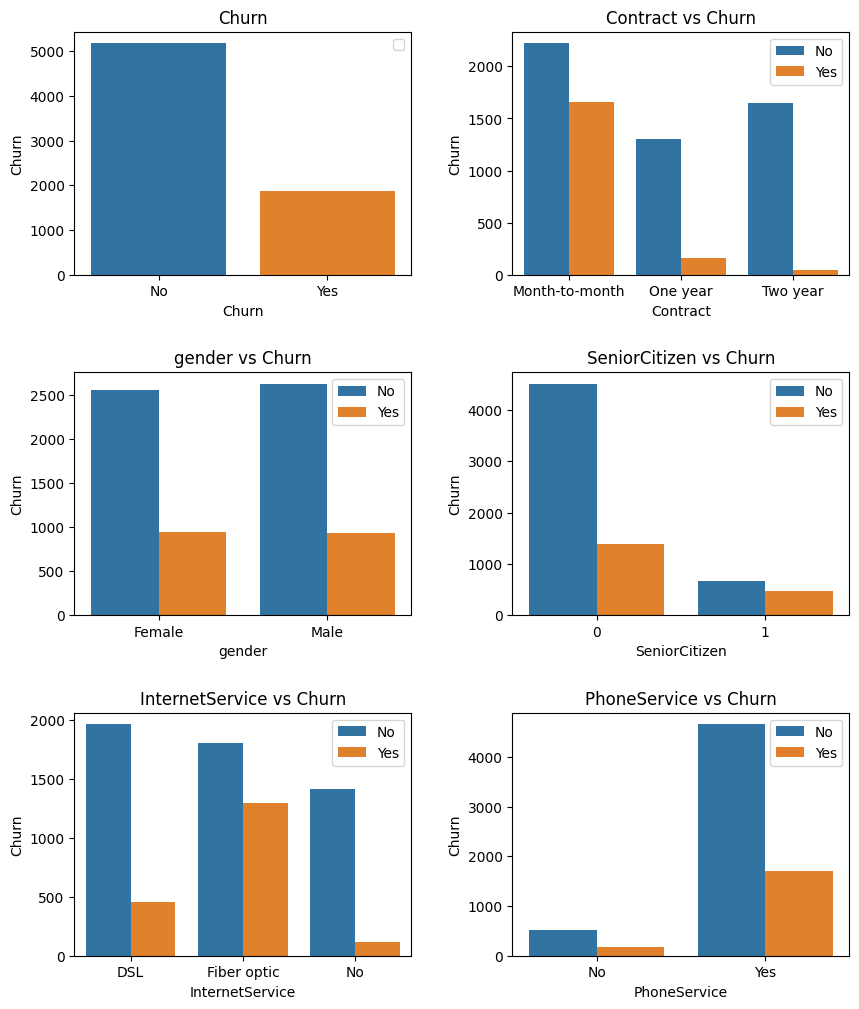

In [109]:
#Visual  data analysis

catFeatures =['Churn','Contract',  'gender',  'SeniorCitizen', 'InternetService', 'PhoneService']

fig , ax = plt.subplots(3,2,figsize = (10,12))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
fig.subplots


for cat, subplot in zip(catFeatures, ax.flatten()) :
  subplot.set_ylabel("Churn")
  if (cat != 'Churn') :
    subplot.title.set_text(cat + ' vs Churn')
  else :
    subplot.title.set_text('Churn')
  sns.countplot(data=ds, x=cat,hue = 'Churn', ax = subplot)
  subplot.legend(loc=1, prop={'size': 10})

plt.show






	


	Min:18.25 Max:118.75 Mean:64.76 Median:70.35


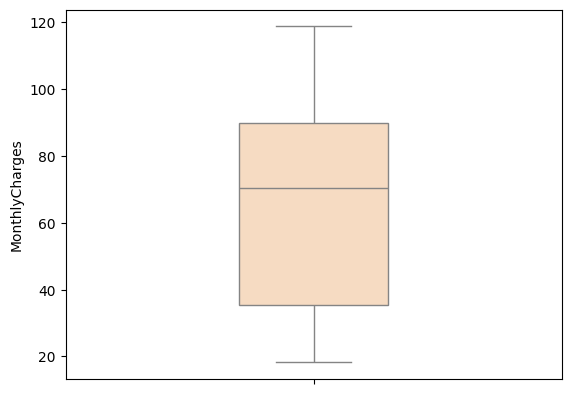




	Min:18.80 Max:8684.80 Mean:2283.30 Median:1397.47


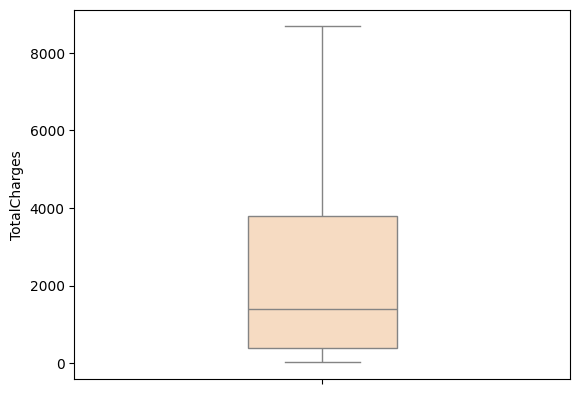

In [110]:
#Analyse the data for any outliers and print the stat along with the box plot
TotalCharges= pd.to_numeric(ds['TotalCharges'], errors='coerce')
monthlyCharges=ds['MonthlyCharges']

monthlyStat= f'\n\n\n\tMin:{monthlyCharges.min():.2f} Max:{monthlyCharges.max():.2f}'
monthlyStat = monthlyStat + f' Mean:{monthlyCharges.mean():.2f} Median:{monthlyCharges.median():.2f}'

print('\n\n\n\t' + monthlyStat)
sns.boxplot(monthlyCharges, width=0.3,color= 'peachpuff')
plt.show()

totalStat= f'Min:{TotalCharges.min():.2f} Max:{TotalCharges.max():.2f}'
totalStat = totalStat + f' Mean:{TotalCharges.mean():.2f} Median:{TotalCharges.median():.2f}'
print('\n\n\n\t' + totalStat)
sns.boxplot(TotalCharges, width =0.3, color = 'peachpuff')
plt.show()


#Data preparation

In [ ]:
#This function prepares the data ready for supervised machine leraning algorithms
def wrangle(ds):
  ds = ds[ds['TotalCharges']!=" "]
  #Convert the total charges column to numeric
  ds['TotalCharges'] = pd.to_numeric(ds['TotalCharges'])
  print(ds.dtypes["TotalCharges"])
  #delete the column custoner ID
  ds.drop('customerID', axis =1, inplace = True)
  #combine the categorical value " No service " to "No"
  ds.loc[ds['MultipleLines']=="No phone service", 'MultipleLines'] ='No'
  ds.loc[ds['OnlineSecurity']=="No internet service", 'OnlineSecurity'] ='No'
  ds.loc[ds['OnlineBackup']=="No internet service", 'OnlineBackup'] ='No'
  ds.loc[ds['DeviceProtection']=="No internet service", 'DeviceProtection'] ='No'
  ds.loc[ds['TechSupport']=="No internet service", 'TechSupport'] ='No'
  ds.loc[ds['StreamingTV']=="No internet service", 'StreamingTV'] ='No'
  ds.loc[ds['StreamingMovies']=="No internet service", 'StreamingMovies'] ='No'

  #Encode the categorical data
  label_encoder = preprocessing.LabelEncoder()
  ds['Churn']= label_encoder.fit_transform(ds['Churn'])

  colListToEncode = ['PaperlessBilling', 'PaymentMethod','Contract','gender',
                     'Partner', 'Dependents', 'PhoneService','InternetService',
                     'MultipleLines','OnlineSecurity','OnlineBackup',
                     'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
  ds = pd.get_dummies(ds,columns=colListToEncode, dtype = int)
  return ds

float64
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  \
0              0       1           29.85         29.85      0   
1              0      34           56.95       1889.50      0   
2              0       2           53.85        108.15      1   
3              0      45           42.30       1840.75      0   
4              0       2           70.70        151.65      1   

   PaperlessBilling_No  PaperlessBilling_Yes  \
0                    0                     1   
1                    1                     0   
2                    0                     1   
3                    1                     0   
4                    0                     1   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (autom

<Axes: >

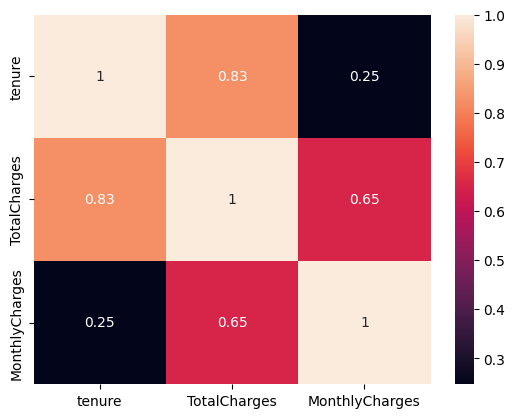

In [ ]:
#3. Prepare the data
tuned_ds= wrangle(ds)
print(tuned_ds.head(5))


#Visual display of Correlation between Ordinal features
ColsToCorelate=['tenure','TotalCharges' , 'MonthlyCharges']
dataToCorrelate = tuned_ds[ColsToCorelate]
sns.heatmap(dataToCorrelate.corr(), annot=True)

In [ ]:
#4. Split the data to train and test
y= tuned_ds['Churn']
X= tuned_ds.drop(columns='Churn', axis =1)

X_train,X_test,Y_train, Y_test = train_test_split(X, y, test_size = 0.3,stratify=y, random_state= 42)
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)


(4922, 38) (2110, 38) (4922,) (2110,)


#Metric Calculation and visual display Functions

In [ ]:
#Display clasification metrics
def classificationMetrics(model, test, pred):
  accuracy = accuracy_score(test, pred)*100
  print("The accuracy score of the model ", model, ' = ',   round(accuracy, 2))
  cmatrix =confusion_matrix(test, pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['No', 'Yes'])
  cm_display.plot()
  plt.show()
  print(classification_report(test , pred))
  print('-------------------------------------')

In [ ]:
#Create a visual for top 10 important features
def dislayFeatureImportance(model, X_train, Y_train):
  colour='Red'
  if not isinstance(model, LogisticRegression) :
    #model_fi = permutation_importance(model, X_train, Y_train)
    #featureImportance =pd.Series(model_fi['importances_mean']    , index=X.columns)
    featureImportance =pd.Series(model.feature_importances_ , index=X.columns)
    if isinstance(model, DecisionTreeClassifier ):
      colour= 'Blue'
    featureImportance.nlargest(5).plot.barh(color=colour)
    plt.title(f'Feature Importance {model}')
    plt.show()


In [ ]:
def calculateROC(model, Y_test, Y_prob):
  fpr, tpr, thresold =roc_curve(Y_test, Y_prob)
  roc_auc=auc(fpr,tpr)
  plt.plot(fpr, tpr, label =f'{model} with roc {roc_auc:.2f}')


#Binary Classification model training

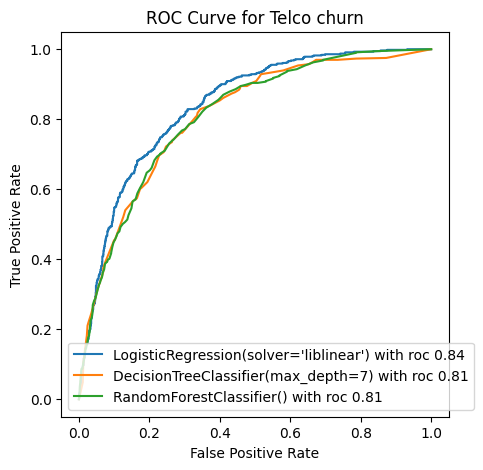

In [ ]:
#5 train the models
maxDepth = 7
models=[LogisticRegression(solver='liblinear'), DecisionTreeClassifier(max_depth=maxDepth), RandomForestClassifier()]
trainedModel=[]
plt.figure(figsize=(5,5), dpi=100)
for model in models :
  if  not isinstance(model, LogisticRegression):
    trainedModel.append(model)
  model.fit(X_train, Y_train)
  Y_pred= model.predict(X_test)
  Y_pred_proba=model.predict_proba(X_test)
  #dislayFeatureImportance(model, X_train, Y_train)
  #classificationMetrics(model, Y_test, Y_pred)
  calculateROC(model, Y_test, Y_pred_proba[:, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telco churn')
plt.legend()
plt.show()


#Model Selection

In [ ]:
#6 cross validation with the same data with 5 Folds and models
for model in models:
  cv_score = cross_val_score(model, X, y, cv= 5)
  print(cv_score)
  accuracy = (sum(cv_score)/len(cv_score))*100
  print("The accuracy score of the model ", model, ' = ',   round(accuracy,2))


[0.80597015 0.81307747 0.79587482 0.80654339 0.80369844]
The accuracy score of the model  LogisticRegression(solver='liblinear')  =  80.5
[0.78891258 0.79530917 0.77596017 0.78805121 0.7972973 ]
The accuracy score of the model  DecisionTreeClassifier(max_depth=7)  =  78.91
[0.7981521  0.78606965 0.7688478  0.78947368 0.80227596]
The accuracy score of the model  RandomForestClassifier()  =  78.9


#Hyperparameter tuning


In [ ]:
#Implement GridSearchCV
param ={
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,1000,2000]}

model= LogisticRegression()
classifier = GridSearchCV(model, param, cv=5)
classifier.fit(X_train, Y_train)
print(classifier.best_params_)
print(f'{classifier.estimator} with {classifier.best_params_} gives the best accuracy : {classifier.best_score_*100:.2f}%')


{'max_iter': 100, 'solver': 'liblinear'}
LogisticRegression() with {'max_iter': 100, 'solver': 'liblinear'} gives the best accuracy : 80.03%


#Feature Importance

<Axes: ylabel='Feature'>

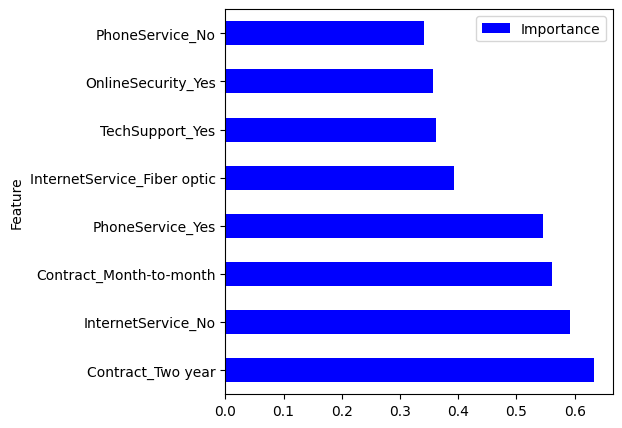

In [ ]:
#plot feature importance from the selected model
model = LogisticRegression(solver='liblinear', max_iter=100)
model.fit(X_train, Y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance=feature_importance.head(8)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(5, 5), color='blue')
